**Table of contents**<a id='toc0_'></a>    
- [Visibility](#toc1_)    
  - [I. Usability elements](#toc1_1_)    
    - [I.I Angle classes](#toc1_1_1_)    
    - [I.II Input data](#toc1_1_2_)    
  - [II. Time](#toc1_2_)    
    - [II.1 Julian Day](#toc1_2_1_)    
    - [II.2 Universal Time](#toc1_2_2_)    
    - [II.3 Sidereal Time](#toc1_2_3_)    
      - [II.3.1 At Greenwich](#toc1_2_3_1_)    
  - [III. Trajectory along the sky](#toc1_3_)    
    - [III.1 Coordinates](#toc1_3_1_)    
  - [IV. Sun](#toc1_4_)    
    - [IV.I Twilight](#toc1_4_1_)    
  - [V. Moon](#toc1_5_)    
    - [V.I Moon Phases](#toc1_5_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Visibility](#toc0_)

## <a id='toc1_1_'></a>[I. Usability elements](#toc0_)

Import required packages 

In [3]:
## required packages
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

### <a id='toc1_1_1_'></a>[I.1 Angle classes](#toc0_)

To handle the different formats in which one can express the value of an angle on celestial sphere (radiants, degrees, hours), two classes of object are defined. These keep the value of an angle in different units and provide some usefull function to convert from one format to an other.

In [4]:
## angle classes
class Angles():
    """Class to handle with angles in degrees or radiants.
    
    The class takes the value of an angle in deg or rad,
    converts one in other and stored the values.

    The format for values in def is a `list` of length 2:
    
      - the first element is a `str` that keeps the sign of the angle

      - the second one is a `numpy.ndarray` of length 3: [deg, pp, ss.ss] 

    The attributes are:

    :ivar rad: the value of the angle in radiants
    :vartype rad: float
    :ivar deg: the value of the angle in deg. The format is [sign, [deg,pp,ss.ss]]
    :vartype deg: list[str, np.ndarray]    
    :ivar lim: the angle is in a range set by [0,`lim`] (see `std_format()` docstring)
    :vartype lim: int
    """

    #: a dictionary to pass from string symbol to integer and vice versa
    strsign = { '+' :  1,
                '-' : -1,
                 1  : '+',
                -1  : '-' }

    @staticmethod
    def decimal(ang: np.ndarray | list) -> float:
        """Function to convert a list angle
        [val, val, val.val] in a float 
        val.val 

        :param ang: angle array value in deg or hms
        :type ang: np.ndarray | list
        
        :return: angle float value
        :rtype: float
        """
        if sum(ang) == 0: return 0
        else: return ang[0] + ang[1]/60 + ang[2]/3600


    @staticmethod
    def std_format(sign: int | str, ang: np.ndarray | list, lim: int | None = 360) -> list:
        """Function to adjust format of a list angle in deg or hms.

        The wanted format is:

          - [`sign`, [deg (<`lim`), pp (<60), ss.ss (<60)]]

          - [`sign`, [hh, mm (<60), ss.ss (<60)]]

        It is possible to change the range of the angle: [0, `lim`]
          
        :param sign: sign of the angle
        :type sign: int | str
        :param ang: angle value
        :type ang: np.ndarray | list
        :param lim: the angle edge , defaults to 360
        :type lim: int | None, optional
        
        :return: correct format for the angle value
        :rtype: list
        """
        # taking the sign as a str
        if type(sign) != str:
            sign = Angles.strsign[sign]
        # copying the angle values
        ang = np.copy(ang)
        # checking for decimal in degrees and primes
        for i in range(2):
            diff = ang[i] % 1
            if diff != 0:
                ang[i] = int(ang[i])
                ang[i+1] += diff*60
        # rounding the seconds 
        ang[2] = round(ang[2], 4)
        # getting the wanted format (see the docstring)
        if ang[2] >= 60 :
            tmp = ang[2]
            ang[2] = tmp % 60
            ang[1] += tmp // 60
            del tmp
        if ang[1] >= 60 :
            tmp = ang[1]
            ang[1] = tmp % 60
            ang[0] += tmp // 60
            del tmp
        # condition only for deg    
        if lim != None:
            if ang[0] > lim :
                ang[0] -= lim * np.trunc(ang[0] / lim).astype(int)
        # collecting the values
        ang = [sign,ang]
        return ang
    
    @staticmethod
    def deg_to_rad(deg: list) -> float:
        """Function to convert deg in rad

        :param deg: list angle in deg
        :type deg: list

        :return: value in radiants
        :rtype: float
        """
        # getting the sign as int
        sign = Angles.strsign[deg[0]]
        # extracting the array values
        ang = deg[1]
        # converting in float
        dec_deg = Angles.decimal(ang)
        # computing radiants
        rad = sign * dec_deg * pi / 180
        return rad

    @staticmethod
    def rad_to_deg(rad: float, lim: int = 360) -> list:
        """Function to convert rad in deg

        :param rad: value in radiants
        :type rad: float
        :param lim: edge of the angle range, defaults to 360
        :type lim: int, optional
        
        :return: list angle in deg
        :rtype: list
        """
        # getting the sign
        sign = np.sign(rad) if rad != 0 else 1
        # computing degrees
        ang = np.abs(rad) * 180 / pi
        # adjusting the format
        deg = Angles.std_format(sign,[ang,0,0],lim=lim)
        return deg

    def __init__(self, ang: float | list | None, unit: str, lim: int = 360) -> None:
        """Constructor of the class

        The function takes a value (`ang`) and the corrisponding 
        unit (`unit`) as input, computes and stores the angle
        values in deg and rad. 

        :param ang: angle value
        :type ang: float | list
        :param unit: unit of angle value, like 'deg' or 'rad'
        :type unit: str
        :param lim: angle edge (see `std_format()` docstring), defaults to 360
        :type lim: int, optional
        """
        # setting lim
        self.lim = lim
        if ang is None:
            self.deg = []
            self.rad = None
        # value in radiants
        elif unit == 'rad':
            self.rad = ang
            self.deg = Angles.rad_to_deg(ang,lim=lim)
        # value in degrees
        elif unit == 'deg':
            # `ang` is a float
            if type(ang) != list:
                # getting the sign
                sign = np.sign(ang) if ang != 0 else 1
                self.deg = Angles.std_format(sign,[np.abs(ang),0,0],lim=lim)
            else:
                self.deg = [ang[0], np.copy(ang[1])]
            self.rad = Angles.deg_to_rad(self.deg)

    def decformat(self) -> float:
        """Function to convert a list angle
        [val, val, val.val] in a float 
        val.val 

        :param ang: angle array value in deg or hms
        :type ang: np.ndarray | list
        
        :return: angle float value
        :rtype: float
        """
        sign = Angles.strsign[self.deg[0]]
        ang = self.deg[1]
        return Angles.decimal(ang)*sign

    def print_angle(self,sel: str = 'all') -> str:
        """Function to print the value of an angle
        in all units

        One can select to print the angle in all 
        units or just one through the `sel`
        parameter:

            - `sel = 'all'`: print value in all units
            - `sel = 'deg'`: print value in deg
            - `sel = 'rad'`: print value in rad

        :param sel: to select in which unit printing the angle, defaults to 'all'
        :type sel: str, optional

        :return: the string with the values
        :rtype: str
        """
        deg_str = 'deg =\t'+self.deg[0]+f'{self.deg[1]}\n'
        rad_str = 'rad =\t'+f'{self.rad/pi} * pi\n'
       
        if sel == 'deg': return deg_str
        elif sel == 'rad': return rad_str
        elif sel == 'all': return deg_str + rad_str
        else: raise Exception(f"!Error in `sel` parameter!\nsel = {sel} is not allowed\nRead the documentation for correct values of the parameter")

    def __add__(self, angle):
        """Function to sum two angles

        :param angle: second angle
        :type angle: Angles

        :return: sum of the angles
        :rtype: Angles
        """
        # check for edges
        if self.lim != angle.lim:
            print('\n!warning: you are summing angles with different limits!\nThe limit of the sum is taken equal to that of ang1\n')
        # computing the sum in rad
        sumrad = self.rad + angle.rad
        return Angles(ang=sumrad,unit='rad',lim=self.lim)

    def __sub__(self, angle):
        """Function to subtract two angles

        :param angle: second angle
        :type angle: Angles

        :return: subtraction of the angles
        :rtype: Angles
        """
        if self.lim != angle.lim:
            print('\n!warning: you are summing angles with different limits!\nThe limit of the sum is taken equal to that of ang1\n')
        subrad = self.rad - angle.rad
        return Angles(ang=subrad,unit='rad',lim=self.lim)

    def __mul__(self,val: float | int):
        """Function to implement the angle-number product

        :param val: a number
        :type val: float | int

        :return: angle-number product
        :rtype: Angles
        """
        return Angles(self.rad*val,'rad',lim=self.lim)
    
    def __neg__(self):
        return self * -1



class HAngles(Angles):
    """This is essentially the same class as :class: `Angles`, keeping in account 
    the description of an angle in [hours, minutes, seconds] format.

    The attributes are:

    :ivar rad: from :class: `Angles`; the value of the angle in radiants; 
    :vartype rad: float
    :ivar deg: from :class: `Angles`; the value of the angle in deg. The format is [sign, [deg,pp,ss.ss]] 
    :vartype deg: list[str, np.ndarray]    
    :ivar deg: the value of the angle in hms. The format is [sign, [hh,mm,ss.ss]]
    :vartype deg: list[str, np.ndarray]    
    :ivar lim: from :class: `Angles`; the angle is in a range set by [0,`lim`] (see `std_format()` docstring)
    :vartype lim: int
    """

    @staticmethod
    def deg_to_hms(deg: list) -> list:
        """Function to convert deg in hms

        1 hour = 15 degrees

        :param deg: list angle in deg
        :type deg: list

        :return: list angle in hms
        :rtype: list
        """
        # getting the sign
        sign = deg[0]
        ang = np.copy(deg[1])
        # converting in float and computing the hours
        ang = Angles.decimal(ang) / 15
        hms = Angles.std_format(sign,[ang,0,0],lim=None)
        return hms
    
    @staticmethod
    def hms_to_deg(hms: list, lim: int = 360) -> list:
        """Function to convert hms in deg

        1 hour = 15 degrees

        :param hms: list angle in hms
        :type hms: list
        :param lim: edge of the angle range, defaults to 360
        :type lim: int, optional

        :return: list angle in deg
        :rtype: list
        """
        # getting the sign
        sign = hms[0]
        ang = np.copy(hms[1])
        # converting in float and computing the degrees
        ang = Angles.decimal(ang) * 15
        deg = Angles.std_format(sign,[ang,0,0],lim=lim)
        return deg
    
    @staticmethod
    def rad_to_hms(rad: float, lim: int = 360) -> list:
        """Function to convert rad in hms

        It pass through the `rad_to_deg()` and
        `deg_to_hms()` functions

        :param rad: angle value in rad
        :type rad: float
        :param lim: edge of the angle range, defaults to 360
        :type lim: int, optional

        :return: list angle in hms
        :rtype: list
        """
        deg = Angles.rad_to_deg(rad,lim=lim)
        hms = HAngles.deg_to_hms(deg)
        return hms
    
    @staticmethod
    def hms_to_rad(hms: list, lim: int = 360) -> float:
        """Function to convert hms in rad

        It pass through the `hms_to_deg()` and
        `deg_to_rad()` functions

        :param rad: list angle in hms
        :type rad: list
        :param lim: edge of the angle range, defaults to 360
        :type lim: int, optional

        :return: angle value in rad 
        :rtype: float
        """
        deg = HAngles.hms_to_deg(hms,lim=lim)
        rad = Angles.deg_to_rad(deg)
        return rad
    
    def __init__(self, ang: float | list | None, unit: str, lim: int = 360):
        """Constructor of the class (inherited from :class: `Angles`)

        The function takes a value (`ang`) and the corrisponding 
        unit (`unit`) as input, computes and stores the angle
        values in deg, rad and hms. 

        :param ang: angle value
        :type ang: float | list
        :param unit: unit of angle value, like 'deg' or 'rad'
        :type unit: str
        :param lim: angle edge (see `std_format()` docstring), defaults to 360
        :type lim: int, optional
        """
        # `Angles.__init__()` function
        super().__init__(ang, unit, lim)
        if ang is None:
            self.hms = []
        # angle in hms
        elif unit == 'hms':
            # `ang` is a float
            if type(ang) != list:
                sign = np.sign(ang) if ang != 0 else 1
                self.hms = Angles.std_format(sign,[np.abs(ang),0,0],lim=None)
            else:
                self.hms = [ang[0], np.copy(ang[1])]
            self.deg = HAngles.hms_to_deg(self.hms,lim=lim)
            self.rad = HAngles.hms_to_rad(self.hms)
        # angle in rad or deg
        else:
            self.hms = HAngles.deg_to_hms(self.deg)
    
    def print_angle(self, sel: str = 'all'):
        """Function to print the value of an angle
        in all units (inherited from :class: `Angles`)

        One can select to print the angle in all 
        units or just one through the `sel`
        parameter:

            - `sel = 'all'`: print value in all units
            - `sel = 'deg'`: print value in deg
            - `sel = 'rad'`: print value in rad
            - `sel = 'hms'`: print value in hms

        :param sel: to select in which unit printing the angle, defaults to 'all'
        :type sel: str, optional

        :return: the string with the values
        :rtype: str
        """
        hms_str = 'hms =\t'+self.hms[0]+f'{self.hms[1]}\n'
        
        if sel == 'hms': return hms_str
        elif sel == 'all': return  super().print_angle(sel=sel) + hms_str
        else: return super().print_angle(sel=sel)

    def decformat(self,unit: str) -> float:
        if unit == 'deg':
            return super().decformat()    
        elif unit == 'hms':
            sign = Angles.strsign[self.hms[0]]
            ang = self.hms[1]
            return Angles.decimal(ang)*sign

    def __add__(self, angle):
        """Function to sum two angles

        :param angle: second angle
        :type angle: Angles

        :return: sum of the angles
        :rtype: Angles
        """
        # check for edges
        if self.lim != angle.lim:
            print('\n!warning: you are summing angles with different limits!\nThe limit of the sum is taken equal to that of ang1\n')
        # computing 
        sumrad = self.rad + angle.rad
        return HAngles(ang=sumrad,unit='rad',lim=self.lim)

    def __sub__(self, angle):
        """Function to subtract two angles

        :param angle: second angle
        :type angle: HAngles

        :return: subtraction of the angles
        :rtype: HAngles
        """        
        if self.lim != angle.lim:
            print('\n!warning: you are summing angles with different limits!\nThe limit of the sum is taken equal to that of ang1\n')
        subrad = self.rad - angle.rad
        return HAngles(ang=subrad,unit='rad',lim=self.lim)

    def __mul__(self,val: float | int):
        """Function to implement the angle-number product

        :param val: a number
        :type val: float | int

        :return: angle-number product
        :rtype: HAngles
        """
        return HAngles(self.rad*val,'rad',lim=self.lim)
    
    def __neg__(self):
        return self * -1



# defining some angles
RIGHT = Angles(90.,'deg')
FLAT = Angles(180.,'deg')

### <a id='toc1_1_2_'></a>[I.2 Interpolation](#toc0_)

It's possible only if III diff $\sim$ 0 when you have more than 3 points

In [5]:
def interpole_three(values: list | np.ndarray, 
                    n: float, 
                    xvalues: list | np.ndarray = [], 
                    centre: float | None = None, 
                    val: str | None = None
                    ) -> float | tuple[float, dict]:
    dim = len(values)
    sample = np.copy(values)
    if dim > 3:
        if centre == None: raise Exception('!Error in central value!\n You have to pass the central value for interpolation')
        if len(xvalues) == 0: raise Exception('!Error in `xvalues`!\n You have to pass x values for interpolation')
        diff = np.diff(sample)
        for i in range(2):
            diff = np.diff(diff)
        maxdiff = diff.max()
        if np.abs(maxdiff) > 2: raise Exception('!Error in interpolation!\nThe third difference is not negligible')
        else:
            idx = (np.abs(xvalues - centre)).argmin()
            sample = sample[idx-1:idx+2] 
    elif dim < 3: raise Exception('!Error in length!\nInterpolation needs three points at least')
    
    centre_val = sample[1]
    a, b = np.diff(sample)
    c = b - a
    result = centre_val + n * (a + b + n*c) / 2
    
    if val != None:
        dval = {}

        if val == 'ym' or val == 'all':
            dval['ym'] = centre_val - (a+b)**2/(8*c)
            dval['nm'] = - (a+b) / (2*c)
        if val == 'n0' or val == 'all':
            n0 = 0
            cnt = 0
            while True:
                dn0 = -(2*centre_val + n0*(a+b+c*n0))/(a+b+2*c*n0)
                n0 += dn0
                cnt += 1
                if np.abs(dn0) < 1e-6:
                    break
                if cnt > 20: 
                    print('Algorithm did not converge for n0!')
                    break
            dval['n0'] = n0 if cnt <= 20 else None    

        result = (result, dval)

    return result    

x = [26.,27.,28.]
y = [-28*60-13.4,6*60+46.3,38*60+23.2]

yi, vals = interpole_three(y,1,val='n0')

print(f"Interpolated: {yi}\nn0 = {vals['n0']}")

del x,y,yi,vals

Interpolated: 2303.2000000000003
n0 = -0.20126729503148005


## <a id='toc1_2_'></a>[II. Time](#toc0_)

### <a id='toc1_2_1_'></a>[II.1 Julian Day](#toc0_)

In [6]:
def julian_day(year: int, month: int, day: float, calendar: str = 'Gregorian', MJD: bool = False) -> float:
    """Computing the Julian Day

    From J.,Meeus, *Astronomical Algorithms*, pg. 61. 
    Follow the same notation.

    Same from M., Gallaway, *An Introduction to Observational Astrophysics*, 
    pg. 41.

    Different in *Explatatory supplement to the Astronomical Almanac*, pg. 604

    :param year: year
    :type year: int
    :param month: month
    :type month: int
    :param day: day 
    :type day: float
    :param calendar: kind of chosen calendar, defaults to 'Gregorian'
    :type calendar: str, optional
    :param MJD: set `True` to have the Modified JD, defaults to False
    :type MJD: bool, optional

    :return: Julian Day
    :rtype: float
    """
    if month <= 2:
        year -= 1
        month += 12
    A = np.floor(year / 100)
    if calendar == 'Gregorian':
        B = (2 - A + np.floor(A / 4)) 
    elif calendar == 'Julian':
        B = 0
    else:
        raise Exception("!ERROR in chosen calendar!\nFunction accepts only the string:\n\t- 'Gregorian'\n\t- 'Julian'")
    JD = np.floor(365.25 * (year + 4716)) + np.floor(30.6001 * (month + 1)) + day + B - 1524.5
    if MJD:
        JD -= 2400000.5
    return JD

# 1957 October 4.81
print(f'Julian Day of 1957 October 4.81:\t{julian_day(1957,10,4.81)}')
# 2023 June 8.417
print(f'Julian Day of 2023 June 8.417:\t{julian_day(2023,6,8.417)}')


def calendar_date(JD: float) -> list:
    """_summary_

    Different in *Explatatory supplement to the Astronomical Almanac*, pg. 605  

    :param JD: _description_
    :type JD: float
    :return: _description_
    :rtype: list
    """
    JD += 0.5
    F, Z = np.modf(JD)
    if Z < 2299161:
        A = Z
    else:
        alpha = np.floor((Z-1867216.25)/36524.25)
        A = Z + 1 + alpha - np.floor(alpha / 4)
    B = A + 1524
    C = np.floor((B-122.1)/365.25)
    D = np.floor(365.25 * C)
    E = np.floor((B-D) / 30.6001)
    
    day = B - D - np.floor(30.6001 * E) + F
    month = E-1 if E < 14 else E-13
    year = C-4716 if month > 2 else C-4715
    return [int(year), int(month), day]


JD = julian_day(2023,6,8.417)
print(f'Date of {JD}:\t{calendar_date(JD)}')




Julian Day of 1957 October 4.81:	2436116.31
Julian Day of 2023 June 8.417:	2460103.917
Date of 2460103.917:	[2023, 6, 8.416999999899417]


### <a id='toc1_2_2_'></a>[II.2 Universal Time](#toc0_)

### <a id='toc1_2_3_'></a>[II.3 Sidereal Time](#toc0_)

#### <a id='toc1_2_3_1_'></a>[II.3.1 At Greenwich](#toc0_)

In [7]:
# Mean ST at Greenwich
def mean_Green_HA(year: int, 
                  month: int, 
                  day: float
                  ) -> HAngles:
    JD = julian_day(year,month,day)
    T = (JD - 2451545) / 36525
    theta0 = 280.46061837 + 360.98564736629 * (JD - 2451545) + 3.87933e-4 * T**2 - T**3 / 3871e4
    theta0 = theta0 / 15
    #! Da capire e rivedere questa parte
    if np.abs(theta0) > 24:
        numbdays = np.trunc(theta0 / 24).astype(int)
        theta0 -= numbdays*24
    if theta0 < 0:
        theta0 += 24
    #!
    return HAngles(theta0,'hms')

date = [1987,4,10]
print('1987 April 10, 0h UT')
HA = mean_Green_HA(*date)
print(HA.print_angle('hms'))

date[-1] += (19 + 21/60) / 24 
print('1987 April 10, 19h 21m UT')
HA = mean_Green_HA(*date)
print(HA.print_angle('hms'))


1987 April 10, 0h UT
hms =	+[13.     10.     46.3668]

1987 April 10, 19h 21m UT
hms =	+[ 8.     34.     57.0896]



## <a id='toc1_3_'></a>[III. Trajectory along the sky](#toc0_)

### <a id='toc1_3_1_'></a>[III.1 Coordinates](#toc0_)

In [8]:
class Equatorial():

    def __init__(self, alpha: HAngles | float | list, delta: HAngles | float | list) -> None:
        if type(alpha) != HAngles:
            alpha = HAngles(alpha,'hms')
        if type(delta) != HAngles:
            delta = HAngles(delta,'deg',lim=90)
        self.alpha = alpha
        self.delta = delta
    
    def ha(self, ST: HAngles) -> HAngles:
        return ST - self.alpha

    def print_values(self, sel: str = 'all'):
        alpha_str = 'alpha:\t'+self.alpha.print_angle('hms')
        delta_str = 'delta:\t'+self.delta.print_angle('deg')
        if sel == 'alpha': return alpha_str
        elif sel == 'delta': return delta_str
        elif sel == 'all': return 'Equatorial Coordinates:\n' + alpha_str + delta_str
        else: raise Exception(f'!Error: `{sel}` is not allowed!\nSee the docstring of `print_values()` function')


class Ecliptical():
    def __init__(self, lon: Angles | float | list, lat: Angles | float | list) -> None:
        if type(lon) != Angles:
            lon = Angles(lon,'deg')
        if type(lat) != Angles:
            lat = Angles(lat,'deg',lim=90)
        self.lon = lon
        self.lat = lat

    def print_values(self, sel: str = 'all'):
        lon_str = 'lambda:\t'+self.lon.print_angle('deg')
        lat_str = 'beta:\t'+self.lat.print_angle('deg')
        if sel == 'lon': return lon_str
        elif sel == 'lat': return lat_str
        elif sel == 'all': return 'Ecliptical Coordinates:\n' + lon_str + lat_str
        else: raise Exception(f'!Error: `{sel}` is not allowed!\nSee the docstring of `print_values()` function')


class AltAz():
    def __init__(self, alt: Angles | float | list, az: Angles | float | list) -> None:
        if type(alt) != Angles:
            alt = Angles(alt,'deg',lim=90)
        if type(az) != Angles:
            az = Angles(az,'deg')
        self.alt = alt
        self.az = az
    
    def print_values(self, sel: str = 'all'):
        alt_str = 'alt:\t'+self.alt.print_angle('deg')
        az_str = 'az:\t'+self.az.print_angle('deg')
        if sel == 'alt': return alt_str
        elif sel == 'az': return az_str
        elif sel == 'all': return 'Local Coordinates:\n' + alt_str + az_str
        else: raise Exception(f'!Error: `{sel}` is not allowed!\nSee the docstring of `print_values()` function')

def equat_to_eclipt(eq_coor: Equatorial, e: Angles) -> Ecliptical:
    alpha = eq_coor.alpha
    delta = eq_coor.delta

    lon = np.arctan( (np.sin(alpha.rad)*np.cos(e.rad) + np.tan(delta.rad)*np.sin(e.rad)) / np.cos(alpha.rad) )
    lat = np.arcsin( np.sin(delta.rad)*np.cos(e.rad) - np.cos(delta.rad)*np.sin(e.rad)*np.sin(alpha.rad) )

    lon = HAngles(lon,'rad')
    if lon.rad < 0: lon = lon + FLAT
    lat = HAngles(lat,'rad',lim=90)
    return Ecliptical(lon,lat)

def eclipt_to_equat(ec_coor: Ecliptical, e: Angles) -> Equatorial:
    lon = ec_coor.lon
    lat = ec_coor.lat

    alpha = np.arctan( (np.sin(lon.rad)*np.cos(e.rad) - np.tan(lat.rad)*np.sin(e.rad)) / np.cos(lon.rad) ) 
    delta = np.arcsin( np.sin(lat.rad)*np.cos(e.rad) + np.cos(lat.rad)*np.sin(e.rad)*np.sin(lon.rad) )

    alpha = HAngles(alpha,'rad')
    if alpha.rad < 0: alpha = alpha + FLAT
    delta = HAngles(delta,'rad',lim=90)
    return Equatorial(alpha,delta)

def equat_to_altaz(eq_coor: Equatorial, LST: HAngles, lat: Angles) -> AltAz:
    delta = eq_coor.delta
    LHA = eq_coor.ha(LST)
    
    az = np.arctan(np.sin(LHA.rad) / (np.cos(LHA.rad)*np.sin(lat.rad) - np.tan(delta.rad)*np.cos(lat.rad)))
    alt = np.arcsin(np.sin(lat.rad)*np.sin(delta.rad) + np.cos(lat.rad)*np.cos(delta.rad)*np.cos(LHA.rad))

    alt = HAngles(alt,'rad',lim=90)
    az = HAngles(az,'rad')
    return AltAz(alt,az)


def altaz_to_equat(loc_coor: AltAz, LST: HAngles, lat: Angles) -> Equatorial:
    alt = loc_coor.alt
    az = loc_coor.az
    
    LHA = np.arctan(np.sin(az.rad) / (np.cos(az.rad)*np.sin(lat.rad) + np.tan(alt.rad)*np.cos(lat.rad)))
    delta = np.arcsin(np.sin(lat.rad)*np.sin(alt.rad) - np.cos(lat.rad)*np.cos(alt.rad)*np.cos(az.rad))

    alpha = LST - LHA
    
    alpha = HAngles(alpha,'rad')
    delta = HAngles(delta,'rad')
    return Equatorial(alpha,delta)

class GeoPos():
    def __init__(self,lon: Angles | float | list, lat: Angles | float | list, h: float) -> None:
        if type(lon) != Angles:
            lon = Angles(lon,'deg')
        if type(lat) != Angles:
            lat = Angles(lat,'deg',lim=90)
        self.lon = lon
        self.lat = lat
        self.h = h

### III.2 Compute trajectory

Altair
Equatorial Coordinates:
alpha:	hms =	+[19.      50.      46.99855]
delta:	deg =	+[ 8.     52.      5.9563]



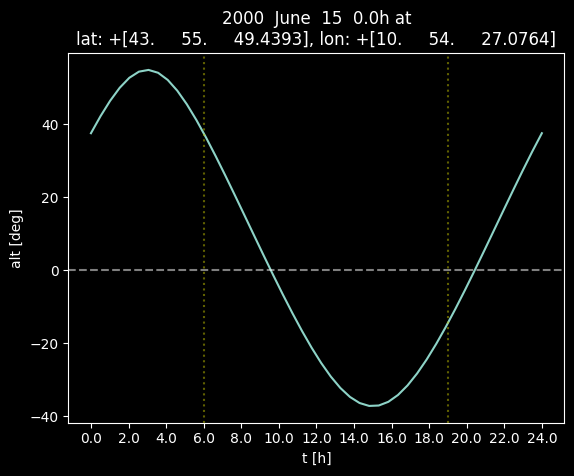

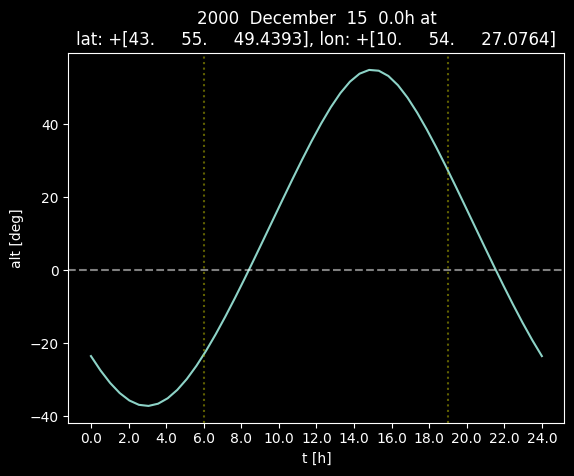

In [60]:
class ArrAngle(HAngles):
    def __init__(self, arrang: np.ndarray | list | None, unit: str, lim: int = 360) -> None:
        if arrang is None or len(unit) == 0:
            self.deg = [] 
            self.rad = []
            self.hms = [] 
            self.lim = lim
        else:
            allvalues = np.array([HAngles(ang,unit=unit,lim=lim) for ang in arrang])

            self.deg = np.array([ Angles.decimal(val.deg[1])*Angles.strsign[val.deg[0]] for val in allvalues]) 
            self.rad = np.array([ val.rad for val in allvalues])
            self.hms = np.array([ Angles.decimal(val.hms[1])*Angles.strsign[val.hms[0]] for val in allvalues]) 
            self.lim = lim

    def __add__(self, arrangle):
        sumangle = self.rad + arrangle.rad
        return ArrAngle(sumangle,'rad',lim=self.lim)
    
    def __sub__(self, arrangle):
        sumangle = self.rad - arrangle.rad
        return ArrAngle(sumangle,'rad',lim=self.lim)
    
    def __mul__(self, val: float | int):
        mulangle = ArrAngle(None,'')
        mulangle.deg = self.deg * val        
        mulangle.rad = self.rad * val        
        mulangle.hms = self.hms * val        
        mulangle.lim = self.lim
        return mulangle

    def __neg__(self):
        return self * -1        



MONTHS = {
    1 : 'January',
    2 : 'February',
    3 : 'March',
    4 : 'April',
    5 : 'May',
    6 : 'June',
    7 : 'July',
    8 : 'August',
    9 : 'September',
    10 : 'October',
    11 : 'November',
    12 : 'December'
}




def trajectory(lat: Angles, lon: Angles, dec: HAngles, ra: HAngles, date: list) -> ArrAngle:
    LST = mean_Green_HA(*date) - lon
    T = np.linspace(0,24,48) + LST.decformat('hms')
    alpha = ra.decformat('hms')
    H = T - alpha
    HA = ArrAngle(H,'hms')

    phi = lat.rad
    delta = dec.rad

    alt = np.arcsin( np.sin(phi)*np.sin(delta) + np.cos(phi)*np.cos(delta) * np.cos(HA.rad)  )

    return ArrAngle(alt,'rad',lim=90), T 

lat = 43.93039980730644
lon = 10.907521220934262 
h = 65

obs = GeoPos(lon,lat,h)

## 
# print('Vega')
# ra = HAngles(['+',[18,36,56.33635]],'hms')
# dec = HAngles(['+',[38,47,1.2802]],'deg',lim=90)
##

## 
# print('Betelgeuse)
# ra = HAngles(['+',[5,55,10.30536]],'hms')
# dec = HAngles(['+',[7,24,25.4304]],'deg',lim=90)
##

## 
print('Altair')
ra = HAngles(['+',[19,50,46.99855]],'hms')
dec = HAngles(['+',[8,52,05.9563]],'deg',lim=90)
##

obj = Equatorial(ra,dec)
print(obj.print_values())

date = [2000,6,15]
JDdate = julian_day(*date)
alt, dayrange = trajectory(obs.lat,obs.lon,dec,ra,date)

hour = (date[2]-np.floor(date[2]))*24

dayrange = np.array([calendar_date(day/24+JDdate)[-1] for day in np.linspace(0,24,48)])#+np.modf(JDdate)[0]*24

plt.figure()
plt.title(f'{date[0]}  {MONTHS[date[1]]}  {int(date[2])}  {hour:.1f}h at\nlat: {obs.lat.deg[0]}{obs.lat.deg[1]}, lon: {obs.lon.deg[0]}{obs.lon.deg[1]}')
plt.plot((dayrange-date[-1])*24,alt.deg)
plt.axhline(0,xmin=0,xmax=1,linestyle='dashed',alpha=0.5,)
plt.xticks(np.arange(0,25,2),np.arange(0,25,2)+hour)
plt.axvline(6.+hour,ymin=0,ymax=1,linestyle='dotted',alpha=0.5,color='y')
plt.axvline(19.-hour,ymin=0,ymax=1,linestyle='dotted',alpha=0.5,color='y')
plt.xlabel('t [h]')
plt.ylabel('alt [deg]')


date = [2000,12,15]
JDdate = julian_day(*date)
alt,dayrange = trajectory(obs.lat,obs.lon,dec,ra,date)

hour = (date[2]-np.floor(date[2]))*24

dayrange = np.array([calendar_date(day/24+JDdate)[-1] for day in np.linspace(0,24,48)])#+np.modf(JDdate)[0]*24

plt.figure()
plt.title(f'{date[0]}  {MONTHS[date[1]]}  {int(date[2])}  {hour:.1f}h at\nlat: {obs.lat.deg[0]}{obs.lat.deg[1]}, lon: {obs.lon.deg[0]}{obs.lon.deg[1]}')
plt.plot((dayrange-date[-1])*24,alt.deg)
plt.axhline(0,xmin=0,xmax=1,linestyle='dashed',alpha=0.5)
plt.xticks(np.arange(0,25,2),np.arange(0,25,2)+hour)
plt.xlabel('t [h]')
plt.ylabel('alt [deg]')
plt.axvline(6.+hour,ymin=0,ymax=1,linestyle='dotted',alpha=0.5,color='y')
plt.axvline(19.-hour,ymin=0,ymax=1,linestyle='dotted',alpha=0.5,color='y')


plt.show()





## <a id='toc1_4_'></a>[IV. Sun](#toc0_)

### <a id='toc1_4_1_'></a>[IV.I Twilight](#toc0_)

## <a id='toc1_5_'></a>[V. Moon](#toc0_)

### <a id='toc1_5_1_'></a>[V.I Moon Phases](#toc0_)